In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

# CIFAR-10 데이터 불러오기 및 전처리

In [2]:
(x_train, y_train_orig), (x_test, y_test_orig) = cifar10.load_data() # 원본 레이블 저장
x_train, x_test = x_train / 255.0, x_test / 255.0
# 원본 레이블 복사 후 One-hot 인코딩 진행
y_train = to_categorical(y_train_orig, 10)
y_test = to_categorical(y_test_orig, 10)

# 잘못된 라벨 시각화

In [3]:
# CIFAR-10 레이블 이름
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

wrong_to_correct_labels = {
    2405: 6,  # frog
    6877: 8,  # ship
    8058: 7,  # horse
    2532: 1,  # automobile
    7657: 7,  # horse
    1969: 9,  # truck
    2804: 5,  # dog
    6792: 9,  # truck
    1227: 5,  # dog
    5191: 5,  # dog
    5690: 4,  # deer
    1718: 8,  # ship
    2592: 4,  # deer
    4794: 2,  # bird
    5960: 3,  # cat
    165:  2,  # bird
    9227: 9,  # truck
    5632: 5,  # dog
    9352: 9,  # truck
    7846: 3,  # cat
    6966: 8,  # ship
    5468: 3   # cat
}

wrong_ids = list(wrong_to_correct_labels.keys())
print(f"수정 대상 Test 데이터 ID 개수: {len(wrong_ids)}개")

수정 대상 Test 데이터 ID 개수: 22개


# 레이블 수정 전 시각화

--- 수정 전 레이블 시각화 ---


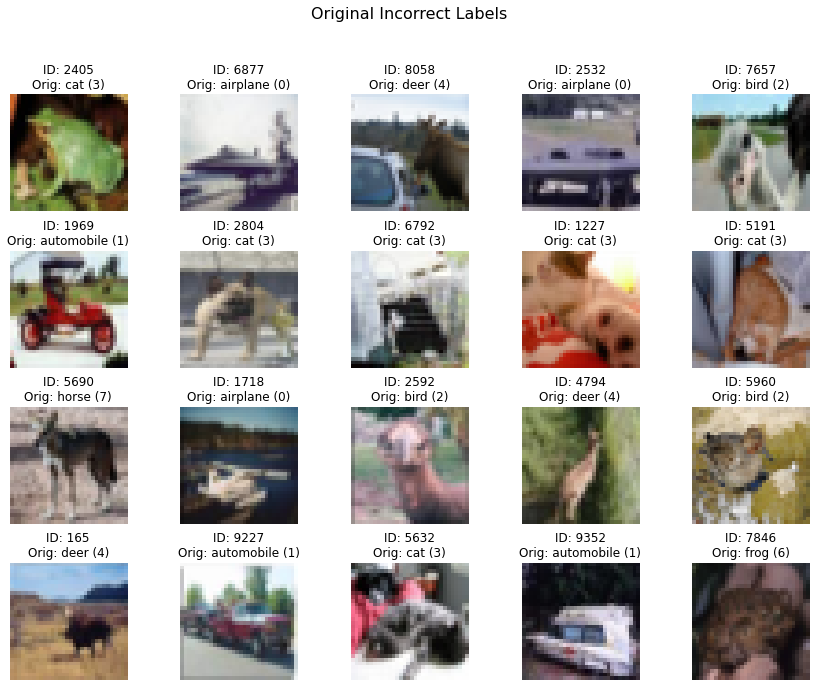


--- Test 데이터 레이블 수정 진행 ---
ID: 2405, Original: 3, Corrected to: 6
ID: 6877, Original: 0, Corrected to: 8
ID: 8058, Original: 4, Corrected to: 7
ID: 2532, Original: 0, Corrected to: 1
ID: 7657, Original: 2, Corrected to: 7
ID: 1969, Original: 1, Corrected to: 9
ID: 2804, Original: 3, Corrected to: 5
ID: 6792, Original: 3, Corrected to: 9
ID: 1227, Original: 3, Corrected to: 5
ID: 5191, Original: 3, Corrected to: 5
ID: 5690, Original: 7, Corrected to: 4
ID: 1718, Original: 0, Corrected to: 8
ID: 2592, Original: 2, Corrected to: 4
ID: 4794, Original: 4, Corrected to: 2
ID: 5960, Original: 2, Corrected to: 3
ID: 165, Original: 4, Corrected to: 2
ID: 9227, Original: 1, Corrected to: 9
ID: 5632, Original: 3, Corrected to: 5
ID: 9352, Original: 1, Corrected to: 9
ID: 7846, Original: 6, Corrected to: 3
ID: 6966, Original: 0, Corrected to: 8
ID: 5468, Original: 5, Corrected to: 3
총 22개의 레이블 수정 완료.


In [4]:
print("--- 수정 전 레이블 시각화 ---")
plt.figure(figsize=(12, 10))
plt.suptitle("Original Incorrect Labels", fontsize=16)
for i, idx in enumerate(wrong_ids[:20]): # 너무 많으면 일부만 표시
    original_label_index = y_test_orig[idx][0]
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test[idx])
    plt.title(f"ID: {idx}\nOrig: {cifar10_labels[original_label_index]} ({original_label_index})")
    plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# --- 실제 레이블 수정 ---
print("\n--- Test 데이터 레이블 수정 진행 ---")
num_corrected = 0
for idx, correct_label_index in wrong_to_correct_labels.items():
    original_label_index = y_test_orig[idx][0]
    if original_label_index != correct_label_index:
        # One-hot 인코딩된 y_test 배열 수정
        y_test[idx] = to_categorical([correct_label_index], num_classes=10)[0]
        print(f"ID: {idx}, Original: {original_label_index}, Corrected to: {correct_label_index}")
        num_corrected += 1
    else:
        # 혹시 labelerrors.com 정보와 초기 데이터가 같은 경우 (그럴 가능성은 낮음)
        print(f"ID: {idx}, Label already correct: {original_label_index}")

print(f"총 {num_corrected}개의 레이블 수정 완료.")

# 레이블 수정 후 시각화


--- 수정 후 레이블 시각화 ---


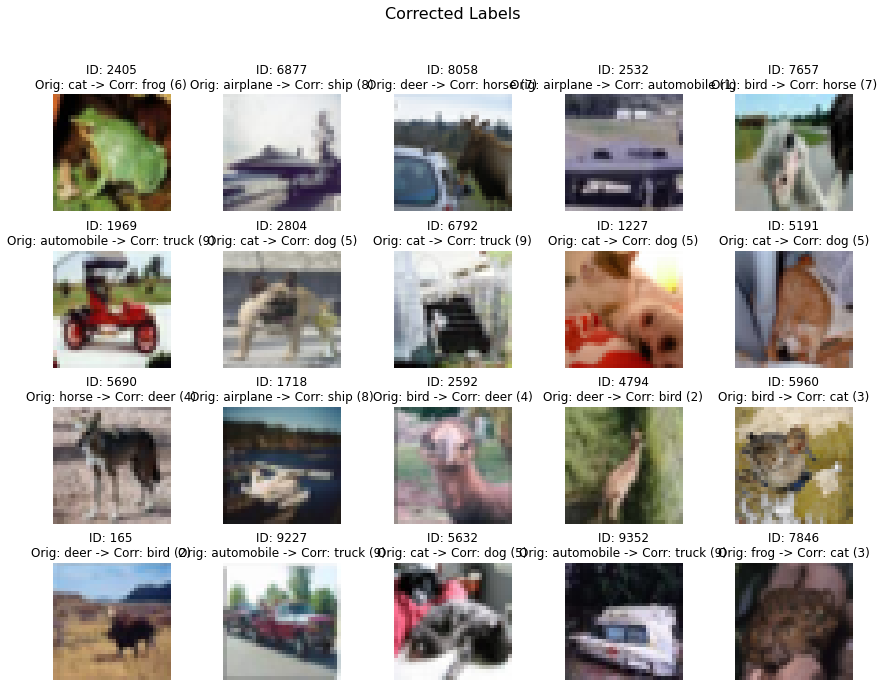

In [5]:
print("\n--- 수정 후 레이블 시각화 ---")
y_test_corrected_indices = np.argmax(y_test, axis=1) # 수정된 y_test에서 인덱스 추출

plt.figure(figsize=(12, 10))
plt.suptitle("Corrected Labels", fontsize=16)
for i, idx in enumerate(wrong_ids[:20]): # 너무 많으면 일부만 표시
    corrected_label_index = y_test_corrected_indices[idx]
    original_label_index = y_test_orig[idx][0] # 비교를 위해 원본 레이블도 가져옴
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test[idx])
    plt.title(f"ID: {idx}\nOrig: {cifar10_labels[original_label_index]} -> Corr: {cifar10_labels[corrected_label_index]} ({corrected_label_index})")
    plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# KerasTuner

In [6]:
# --- 모델 정의 함수 (하이퍼파라미터 튜닝용) ---
def build_hyper_model(hp):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(256, activation='relu')) # Dense 유닛 수는 고정

    # Dropout 비율을 튜닝 대상으로 설정
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout))

    model.add(Dense(10, activation='softmax'))

    # 학습률(Learning Rate)을 튜닝 대상으로 설정
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy', # y_test가 one-hot 이므로
                  metrics=['accuracy'])
    return model

In [7]:
# --- KerasTuner 설정 및 실행 ---
tuner = kt.RandomSearch(
    build_hyper_model,
    objective='val_accuracy', # 검증 데이터 정확도를 기준으로 최적 모델 선택
    max_trials=10,  # 시도할 하이퍼파라미터 조합 수 (시간 고려하여 조절)
    executions_per_trial=2, # 각 조합을 몇 번 실행할지 (안정성 위해 2 이상 권장)
    directory='cifar10_tuning', # 튜닝 결과 저장 디렉토리
    project_name='cifar10_hyperparameter_tuning'
)

# 콜백 설정 (예: 조기 종료)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("\n--- 하이퍼파라미터 튜닝 시작 ---")
tuner.search(x_train, y_train,
             epochs=20, 
             validation_split=0.2,
             callbacks=[early_stopping])

# --- 최적 하이퍼파라미터 확인 ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
최적 하이퍼파라미터:
Dropout rate: {best_hps.get('dropout')}
Learning rate: {best_hps.get('learning_rate')}
""")

# --- 최적 모델 빌드 ---  
print("\n--- 최적 하이퍼파라미터로 최종 모델 빌드 ---")
final_model = tuner.hypermodel.build(best_hps)

Trial 9 Complete [00h 02m 43s]
val_accuracy: 0.71424999833107

Best val_accuracy So Far: 0.7193500101566315
Total elapsed time: 00h 18m 28s

최적 하이퍼파라미터:
Dropout rate: 0.4
Learning rate: 0.0005


--- 최적 하이퍼파라미터로 최종 모델 빌드 ---


In [8]:
# --- 모델 구조 확인 ---
print("\n--- 최종 모델 구조 확인 ---")
final_model.summary()  # 모델 요약 정보 출력


--- 최종 모델 구조 확인 ---
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d_2 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_1 (Flatten)          (Non

In [9]:
print("\n--- 최적 하이퍼파라미터로 최종 모델 학습 시작 ---")
history = final_model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping]) # 수정된 y_test로 검증


--- 최적 하이퍼파라미터로 최종 모델 학습 시작 ---
Epoch 1/50
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5294 - accuracy: 0.4871 - val_loss: 1.2446 - val_accuracy: 0.5611
Epoch 2/50
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0337 - accuracy: 0.6375 - val_loss: 1.0398 - val_accuracy: 0.6418
Epoch 3/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8673 - accuracy: 0.6974 - val_loss: 1.2980 - val_accuracy: 0.5667
Epoch 4/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7549 - accuracy: 0.7373 - val_loss: 1.0174 - val_accuracy: 0.6552
Epoch 5/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6580 - accuracy: 0.7680 - val_loss: 0.8382 - val_accuracy: 0.7120
Epoch 6/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5724 - accuracy: 0.7986 - val_loss: 0.8838 - val_accuracy: 0.7046
Epoch 7/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5063 - accuracy: 0.8190 -

In [10]:
# --- 최종 모델 평가 (수정된 테스트 데이터 사용) ---
print("\n--- 최종 모델 평가 (수정된 Test 데이터) ---")
loss, accuracy = final_model.evaluate(x_test, y_test) # 수정된 y_test 사용!
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- 모델 저장 (SavedModel 형식) ---
print("\n--- 최종 모델 저장 ---")
final_model.save("cifar10_corrected_tuned_model") # 원하는 이름으로 저장
print("모델이 'cifar10_corrected_tuned_model' 폴더에 SavedModel 형식으로 저장되었습니다.")


--- 최종 모델 평가 (수정된 Test 데이터) ---
313/313 [==============================] - 1s 3ms/step - loss: 1.0596 - accuracy: 0.7034
Test Loss: 1.0596
Test Accuracy: 0.7034

--- 최종 모델 저장 ---
INFO:tensorflow:Assets written to: cifar10_corrected_tuned_model/assets
모델이 'cifar10_corrected_tuned_model' 폴더에 SavedModel 형식으로 저장되었습니다.
